# Lotka-Volterra predator-prey model

[Predator-prey dynamics](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations), as modeled with Lotka-Volterra equations, are one of the most ubiquitous example used to introduce complex systems modeling with differential equations. Yet, it is a ridiculous example! The version we will consider goes as follows. Prey (fish) reproduce logistically based on a rate $\alpha$ in an environment with carrying capacity $K$. Any predator (shark) can come into contact and eat any fish at a given rate $\beta$. This act of predation gives energy to the shark thereby allowing it to reproduce. Sharks eventually die of old age at a rate $\gamma$. It is a fun model, but the mean-field equations commonly used miss a critical point: Animals are *discrete* quantities!

Despite this approximation, classic [Lotka-Volterra equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) yield some interesting insights about cycles in the population of predators and prey. This explained why the Adriatic Sea was populated with predators after World War I, despite a reduction in fishing of preys by humans. The explanation is not entirely convincing, however, as these cycles can go arbitrarily close to null populations, which are absorbing state. Indeed, the further out of equilibrium the dynamics, the lower the density of predators and preys will eventually go. The mean-field model can thus produce densities of animals as low as $10^{10}$ that will eventually rebound back! In regimes with cycles, the model does not allow extinctions.

Master equations can help get a more complete picture of the model! They can capture the stochastic nature of the mechanisms as well as the discrete nature of foxes, rabbits, sharks, or fish.

## Lotka-Volterra master equations

Using the mechanisms described in introduction, we can go through our usual recipe. We ask:

*What is the set of discrete states available to the system?* The system is fully described by a discrete number of preys $n_1$ and a discrete number of predators $n_2$, both of which can take any value from 0 to infinity.

*What are the possible transitions between states?* The system will go from state $(n_1, n_2)$ to state $(n_1+1, n_2)$ trough prey reproduction, from state $(n_1, n_2)$ to state $(n_1-1, n_2+1)$ through predation, and from state $(n_1, n_2)$ to state $(n_1, n_2-1)$ through predator death.

*At what rates do these transitions occur?* $J_{(n_1, n_2)\rightarrow (n_1+1, n_2)} = \alpha n_1(K-n_1)$ and $J_{(n_1, n_2)\rightarrow (n_1, n_2-1)} = \gamma n_2$ and $J_{(n_1, n_2)\rightarrow (n_1-1, n_2+1)} = \beta n_1 n_2$. All other transitions are impossible (null current equal to zero).

Combining all these terms, we get the following master equation.

$$
\begin{align}
\frac{d}{dt}P_{n_1,n_2}(t) &= -\alpha n_1(K-n_1)P_{n_1,n_2}(t) - \gamma n_2 P_{n_1,n_2}(t) - \beta n_1 n_2 P_{n_1,n_2}(t) \\
& + \alpha (n_1-1)(K-n_1+1)P_{n_1-1,n_2}(t) + \gamma (n_2+1) P_{n_1,n_2+2}(t) + \beta (n_1+1)(n_2-1) P_{n_1+1,n_2-1}(t)
\end{align}
$$

This model (and most of its variants) can be simplified as we've seen before using the method of moments. Or we can use a more common approach and numerically integrate the master equation in time. 

/var/folders/qs/h2k9jxts0n34jj1zq8z7dvtw0000gn/T/ipykernel_8112/228403710.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['ggplot', 'seaborn-talk'])


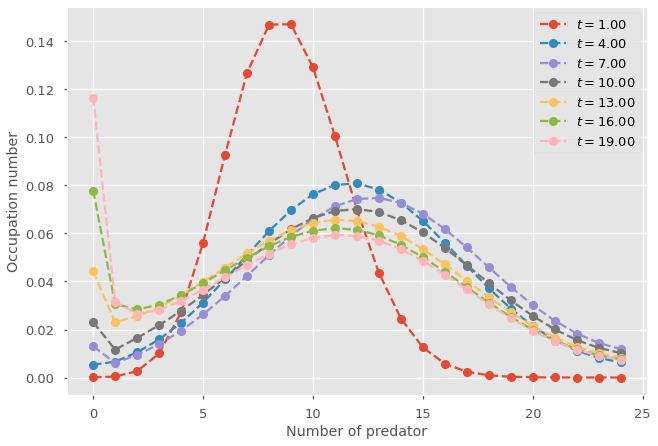

In [174]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
plt.style.use(['ggplot', 'seaborn-talk'])

# We will use the odeint routine
from scipy.integrate import odeint
# With a wrapper to facilitate 2d arrays
from odeintw import odeintw

# Master Equations
@jit(nopython=True)
def J(x, t, alpha, gamma, beta):
    """
    Time derivative of the occupation numbers.

        * x is the state distribution (array like)
        * t is time (scalar)
        * alpha is the prey birth rate
        * gamma is the predator death rate
        * beta is the predation rate
        * NB: We use logistic growth for preys to limit the # of states
        * K will be the carrying capacity
    """
    
    K = x.shape[0]
    
    dx = 0*x
    for n1, n2 in np.ndindex(x.shape):
        dx[n1,n2] -= gamma*n2*x[n1,n2] #predator death output
        if n1<x.shape[0]-1: #prey birth output
            dx[n1,n2] -= alpha*n1*(K-n1)*x[n1,n2]/K
        if n2<x.shape[1]-1: #predation output
            dx[n1,n2] -= beta*n1*n2*x[n1,n2]
        if n1>0: #prey birth input
            dx[n1,n2] += alpha*(n1-1)*(K-n1+1)*x[n1-1,n2]/K
        if n2<x.shape[1]-1: #predator death input 
            dx[n1,n2] += gamma*(n2+1)*x[n1,n2+1]
        if n1<x.shape[0]-1 and n2>0: #predation input
            dx[n1,n2] += beta*(n1+1)*(n2-1)*x[n1+1,n2-1]

    return dx

# Time of observations
t_length = 40
t_steps = 40
t_vec = np.linspace(0, t_length, t_steps)

# Initial conditions
nb_of_states = 25
x_0 = np.zeros((nb_of_states,nb_of_states))
x_0[12,8] = 1

# Parameters
alpha = 0.9
gamma = 0.4
beta = 0.04

# Integration
G = lambda x, t: J(x, t, alpha, gamma, beta)
x_path = odeintw(G, x_0, t_vec)

# Plot
for t in np.arange(1,22,3):
    plt.plot(range(nb_of_states),np.sum(x_path[t],axis=0), marker="o", ls='--', label=fr"$t = {t_length*t/t_steps:.2f}$")
plt.legend()
plt.ylabel('Occupation number')
plt.xlabel('Number of predator')
plt.show()

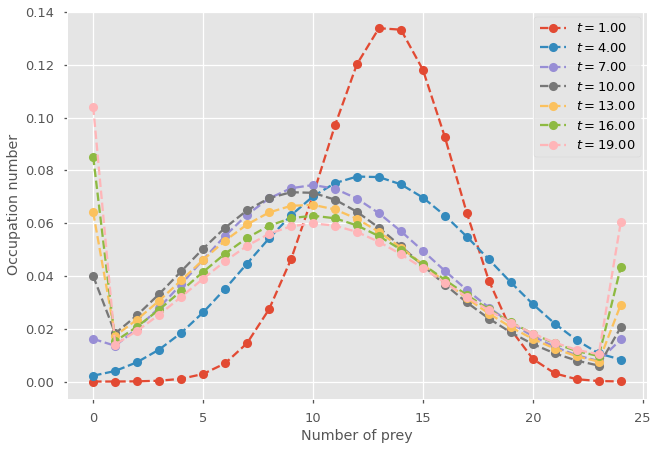

In [165]:
# Plot
for t in np.arange(1,22,3):
    plt.plot(range(nb_of_states),np.sum(x_path[t],axis=1), marker="o", ls='--', label=fr"$t = {t_length*t/t_steps:.2f}$")
plt.legend()
plt.ylabel('Occupation number')
plt.xlabel('Number of prey')
plt.show()

The evolution of the state distribution shows feature of the classic Lotka-Volterra cycles. The mode of the distribution of preys initially goes down then back up, and conversely for the number of predators. However, just like the average of an infinite number of simulations would, the master equations converge towards a near steady-state distribution over all states. However, there exist a few absorbing states that preclude a truly fixed distribution of co-existence states for predators and preys...

To help, we can look at our final time step and visualize the joint-distribution of predator-prey numbers. The figure below highlights the different possible scenarios. Both species can dynamically co-exist for some time, but also: both can go extinct, or preys can rule the Earth! Obviously, none of these scenarios are particularly well described by the average of all possible outcomes. More importantly, the last two are absorbing states. Without predators, prey populations will never go down $(n_1=K, n_2=0)$. Without prey, predators can only die leading to full extinction $(n_1=0, n_2=0)$.

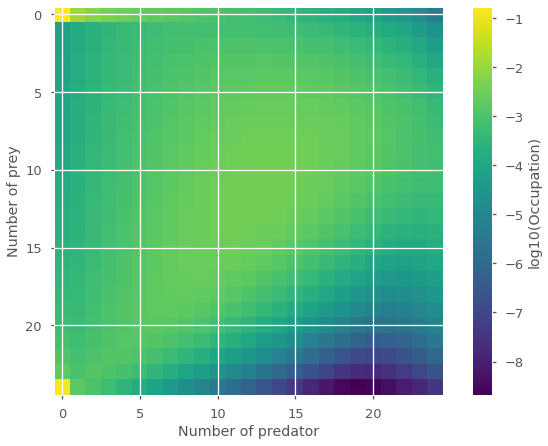

In [167]:
# Plot
im = plt.imshow(np.log10(x_path[-1]))
cbar = plt.colorbar(im)
plt.ylabel('Number of prey')
plt.xlabel('Number of predator')
cbar.set_label('log10(Occupation)')
plt.show()

:::{tip}
Once again, we can check that our occupation numbers are still normalized to attempt to detect any mistake in our probability current or handling of boundary conditions.
:::

In [166]:
print(np.sum(x_path[-1]))

0.9999999999999997
